In [163]:
#!pip install plotguy
#!pip install hkfdb
#!pip install yfinance --upgrade
#!pip install talib-binary

In [164]:
import os
import sys
import copy
import datetime
import time
import itertools

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
#import plotguy

import yfinance as yf
import talib as ta

In [165]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [166]:
#import own data manipulation toolkit
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Algorithmic trading')
import _datatoolkit as dtk

Defining Data Folder Structures

In [167]:
#data folder structures
data_folder = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/data'
backtest_output_folder = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/backtest_output'

**Define Tickers List, Backtest Date Range and Data Retrival Intervals**

In [168]:
# define list of tickers to backtest
#ticker_list = ['ARCC', 'STAG', 'O', 'WPC', 'MAIN', 'ABR', 'ACRE', 'DIVO', 'JEPI', 'LTC', 'OHI', 'PFLT', 'QYLD', 'SCHD', 'STOR', 'XRMI']
ticker_list = ['ABBV', 'CWEN', 'WPC', 'IRM', 'DIVO', 'LTC', 'MOS', 'UVXY', 'ARCC', 'APA']

# define date range
start_date = '2019-03-20'
end_date = '2021-12-31'
interval = '1d'

# initial capital in USD
initial_capital = 8000

# position sizing
pos_size = round(initial_capital/len(ticker_list),2)

**Getting OHLC Data from Yahoo Finance** </b>


*   Get stock data based on ticker list from Yahoo Finance
*   Create each stock data as different dataframe
*   Add Technical Analysis indicators from TA-Lib
*   Pointing working directory to data folder, export dach dataframe as independent csv file 





In [169]:
# changing working directory to data folder's path
data_folder = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/data'
os.chdir(data_folder)

# getting OHLC data from yfinance package, if auto_adjust=True, OHLC data will not have adj close column, use progress=False to get rid of comments
# Other indicators: 14 day RSI
for ticker in ticker_list:
  try:
    globals()[ticker] = pd.DataFrame
    globals()[ticker] = yf.download(ticker, start=start_date, end=end_date, interval=interval, auto_adjust=True, back_adjust=True, progress=False)
    globals()[ticker]['50EMA'] = ta.EMA(globals()[ticker]['Close'], timeperiod=50)
    globals()[ticker]['200EMA'] = ta.EMA(globals()[ticker]['Close'], timeperiod=200) 
    globals()[ticker]['ATR'] = ta.ATR(globals()[ticker]['High'], globals()[ticker]['Low'], globals()[ticker]['Close'], timeperiod=14)
    globals()[ticker]['RSI'] = ta.RSI(globals()[ticker]['Close'], timeperiod=14)
    globals()[ticker]['MACD'], globals()[ticker]['MACD_signal'], globals()[ticker]['MACD_hist'] = ta.MACD(globals()[ticker]['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    globals()[ticker]['ADX'] = ta.ADX(globals()[ticker]['High'], globals()[ticker]['Open'], globals()[ticker]['Close'], 14)
    globals()[ticker] = globals()[ticker].drop(['Volume', 'MACD_hist'], axis=1)
    globals()[ticker] = globals()[ticker].round(4).dropna()
    globals()[ticker] = globals()[ticker].reset_index()
    globals()[ticker]['Position'] = 0
    globals()[ticker][['Equity Value', 'MDD_dollar', 'PNL']] = np.NAN
    
    #writing each ticker dataframe into separate .csv files, save to google drive
    #globals()[ticker].to_csv(ticker+'.csv', index=False, header=True)
  except:
    print(globals()[ticker])

**Other Optional Indicators:** </b>

**MACD_hist** - globals()[ticker]['MACD'], globals()[ticker]['MACD_signal'], globals()[ticker]['MACD_hist'] = ta.MACD(globals()[ticker]['Close'], fastperiod=12, slowperiod=26, signalperiod=9) </b>

**ADXR** - globals()[ticker]['ADXR'] = ta.ADXR(globals()[ticker]['High'], globals()[ticker]['Open'], globals()[ticker]['Close'], 14)


In [170]:
#df_list = [ARCC, STAG, O, WPC, MAIN, ABR, ACRE, DIVO, JEPI, LTC, OHI, PFLT, QYLD, SCHD, STOR, XRMI]
df_list = [ABBV, CWEN, WPC, IRM, DIVO, LTC, MOS, UVXY, ARCC, APA]

**Back Testing** </b>


*   Backtesting of Trade Logic across all tickers and in the designated timeframe
*   Backtesting for Trade strategy with simulated PNL



In [171]:
# Class to call Pandas by row and column
# https://stackoverflow.com/questions/28754603/indexing-pandas-data-frames-integer-rows-named-columns 
class XLocIndexer:
    def __init__(self, frame):
        self.frame = frame
    
    def __getitem__(self, key):
        row, col = key
        return self.frame.iloc[row][col]

pd.core.indexing.IndexingMixin.xloc = property(lambda frame: XLocIndexer(frame))

In [172]:
def backtest(df):
  #start_index = 0
  #end_index = len(df)
  pos_size = 1000
  pos_opened = False
  open_price  = 0
  close_price = 0
  
  pnl = 0
  pnl_list = []
  
  lot_size = 0
  initial_equity_value = 0
  stop_loss = initial_equity_value * 0.1
  profit_target = initial_equity_value * 1.06

  for i in range(len(df)):
    now_open        = df.loc[i, 'Open']
    now_close       = df.loc[i, 'Close']
    now_50EMA       = df.loc[i, '50EMA']
    now_200EMA      = df.loc[i, '200EMA']
    now_rsi         = df.loc[i, 'RSI']
    now_MACD        = df.loc[i, 'MACD']
    now_MACD_signal = df.loc[i, 'MACD_signal']
    now_ADX         = df.loc[i, 'ADX']
    now_position    = df.loc[i, 'Position']
    now_equity_val  = df.loc[i, 'Equity Value']
    now_mdd_dollar  = df.loc[i, 'MDD_dollar']

    # opening a position
    if (pos_opened == False) and ((now_MACD > now_MACD_signal) and (now_rsi < 45)):
      pos_opened = True
      open_price = now_open
      lot_size = pos_size//open_price
      buy_commission = (0.0049 + 0.005) * lot_size
      initial_equity_value = ((lot_size * open_price) - buy_commission)
      df.loc[i, 'Position'] = 1
      df.loc[i, 'Equity Value'] = initial_equity_value
    
    # closing a position
    elif (pos_opened == True) and (now_MACD < now_MACD_signal):
      pos_opened = False
      close_price = now_open
      sell_commission = (0.04 * lot_size) + (close_price * lot_size * 0.0000229)
      pnl = (close_price - open_price) * lot_size - sell_commission
      df.loc[i, 'Position'] = 2
      df.loc[i, 'Equity Value'] = (now_open * lot_size)
      df.loc[i, 'MDD_dollar']     = (now_close * lot_size) - initial_equity_value
      df.loc[i, 'PNL'] = pnl
      pnl_list.append(pnl)

      # reset values
      open_price = 0
      close_price = 0
      initial_equity_value = 0
      lot_size = 0
      stop_loss = 0

    # calculating daily drawdowns
    #else (pos_opened == True):
    elif (pos_opened==True):
      #df.loc[i, 'Position'] = 1
      df.loc[i, 'Equity Value']   = (now_close * lot_size)
      df.loc[i, 'MDD_dollar']     = (now_close * lot_size) - initial_equity_value
 
  total_profit = round(sum(pnl_list), 2)
  num_of_trade = round(len(pnl_list), 2)
  avg_pnl = total_profit/ num_of_trade if num_of_trade else 0

  return num_of_trade, total_profit, avg_pnl

  var = backtest(df)

**Calculating Total PNL**

In [173]:
backtest_values = []
transactions = []

for ticker in df_list:
  try:
    result = backtest(ticker)
    backtest_values.append(list(result))
    
    backtest_dict = dict(zip(ticker_list, backtest_values))
    backtest_raw = pd.DataFrame(backtest_dict.items(), columns=['Ticker', 'Values'])
    backtest_result = pd.concat([backtest_raw['Ticker'], pd.DataFrame(backtest_raw['Values'].tolist())],axis = 1)
    backtest_result.columns = ['Ticker', 'No of Trade', 'Total PNL', 'Avg PNL/ Trade']
    Full_PNL = backtest_result['Total PNL'].sum().round(2)
  except:
    print('No Trade')

In [174]:
#measure_date = df_list[0][1, 'Date']
#print('Trade period:', (measure_date.strftime('%Y-%m-%d')), 'to', end_date)
ROI = ((Full_PNL/ initial_capital)*100).round(2)
print('Total No of Trades Executed:', (backtest_result['No of Trade'].sum()))
print('Total PNL: USD', Full_PNL)
print('Required Capital: USD', initial_capital)
print('ROI: ', ROI, '%')
backtest_result.sort_values(by=['Total PNL', 'Avg PNL/ Trade'], ascending=False)

Total No of Trades Executed: 46
Total PNL: USD 1288.96
Required Capital: USD 8000
ROI:  16.11 %


,Ticker,No of Trade,Total PNL,Avg PNL/ Trade
9,APA,4,1344.12,336.030
8,ARCC,2,384.29,192.145
0,ABBV,5,337.13,67.426
5,LTC,8,257.04,32.130
2,WPC,3,131.25,43.750
4,DIVO,1,120.61,120.610
1,CWEN,1,-57.50,-57.500
6,MOS,3,-140.25,-46.750
3,IRM,4,-222.14,-55.535
7,UVXY,15,-865.59,-57.706


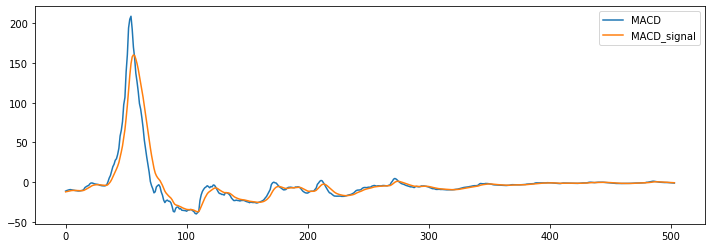

In [175]:
UVXY[['MACD', 'MACD_signal']].plot(figsize=(12,4))

In [176]:
# show all dataframe names in session
# https://stackoverflow.com/questions/44835358/pandas-list-of-dataframe-names
#all_df_in_mem = %who_ls DataFrame
#all_df_in_mem
